# TensorFlow template｜Boston dataset

## summary

- [ボストン住宅価格のデータセット]を用いたTensorFlowのチュートリアル.
- 単回帰モデル, 重回帰モデル, DNNモデルの各モデルについて, 交差検証で訓練を行い平均絶対誤差でスコアを比較します.

## References

⬜ [Boston housing data](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/)     
⬜ [TensorFlow tutorial](https://www.tensorflow.org/tutorials/keras/regression?hl=ja)    
⬜ [Kaggle - Boston Housing Price dataset with Keras](https://www.kaggle.com/code/shanekonaung/boston-housing-price-dataset-with-keras)     

----

## 0. 準備

[Apple Silicon(M1)環境](https://blog.amedama.jp/entry/apple-silicon-python-miniforge)

### 0-1. 仮想環境の起動

```Terminal
conda activate tensorflow
```

### 0-2. 設定 & ライブラリ読み込み

In [1]:
!which python

/usr/local/bin/python


In [1]:
# !pip install -q pandas
# !pip install -q seaborn
# !pip install -q joblib

In [2]:
""" ライブラリ読み込み"""
import os
# pandas
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format # 表示設定

# Helper libraries
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

# TensorFlow and tf.keras
import tensorflow as tf
import keras
from keras import layers


In [3]:
class Context:
    """ 分析の設定

    Attributes:
        data_dir: データ読み込みフォルダ
        data_file: データファイル名
        data_url: データURL
        data_columns: 列名
        label: ラベル名
    """
    data_dir = "path/to/data"  # データフォルダ
    data_file = ""  # ファイル名
    data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data'  # データURL
    data_columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE',
                    'DIS', 'RAD', 'TAX', 'PTRATIO', 'B ', 'LSTAT', 'MEDV']  # 列名
    label = 'MEDV'  # 目的変数
    
    @classmethod
    def __str__(cls) -> str:
        return f"""
    Context:==============================================
    data_dir: {Context.data_dir}
    data_file:  {Context.data_file}
    data_source: {Context.data_url if Context.data_url else os.path.join(Context.data_dir, Context.data_file)}
    data_columns: {Context.data_columns}
    label   : {Context.label}
    """
    
    @classmethod
    def load_data(cls) -> pd.DataFrame:
        df = []
        if Context.data_url:
            df = pd.read_csv(Context.data_url, names=Context.data_columns,
                             na_values='?', comment='\t', sep=' ', skipinitialspace=True)
        else:
            df = pd.read_csv(os.path.join(Context.data_dir, Context.data_file))
        return df

----

## 1. データセットの読み込み & 相関係数チェック

**手順**

- データセット読み込み
- 可視化チェック

In [4]:
""" データセットの読み込み & 統計量確認を行う"""
raw_dataset = Context.load_data()
pd.DataFrame(raw_dataset).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CRIM,506.00,3.61,8.60,0.01,0.08,0.26,3.68,88.98
ZN,506.00,11.36,23.32,0.00,0.00,0.00,12.50,100.00
INDUS,506.00,11.14,6.86,0.46,5.19,9.69,18.10,27.74
CHAS,506.00,0.07,0.25,0.00,0.00,0.00,0.00,1.00
NOX,506.00,0.55,0.12,0.39,0.45,0.54,0.62,0.87
RM,506.00,6.28,0.70,3.56,5.89,6.21,6.62,8.78
AGE,506.00,68.57,28.15,2.90,45.02,77.50,94.07,100.00
DIS,506.00,3.80,2.11,1.13,2.10,3.21,5.19,12.13
RAD,506.00,9.55,8.71,1.00,4.00,5.00,24.00,24.00
TAX,506.00,408.24,168.54,187.00,279.00,330.00,666.00,711.00


<AxesSubplot: >

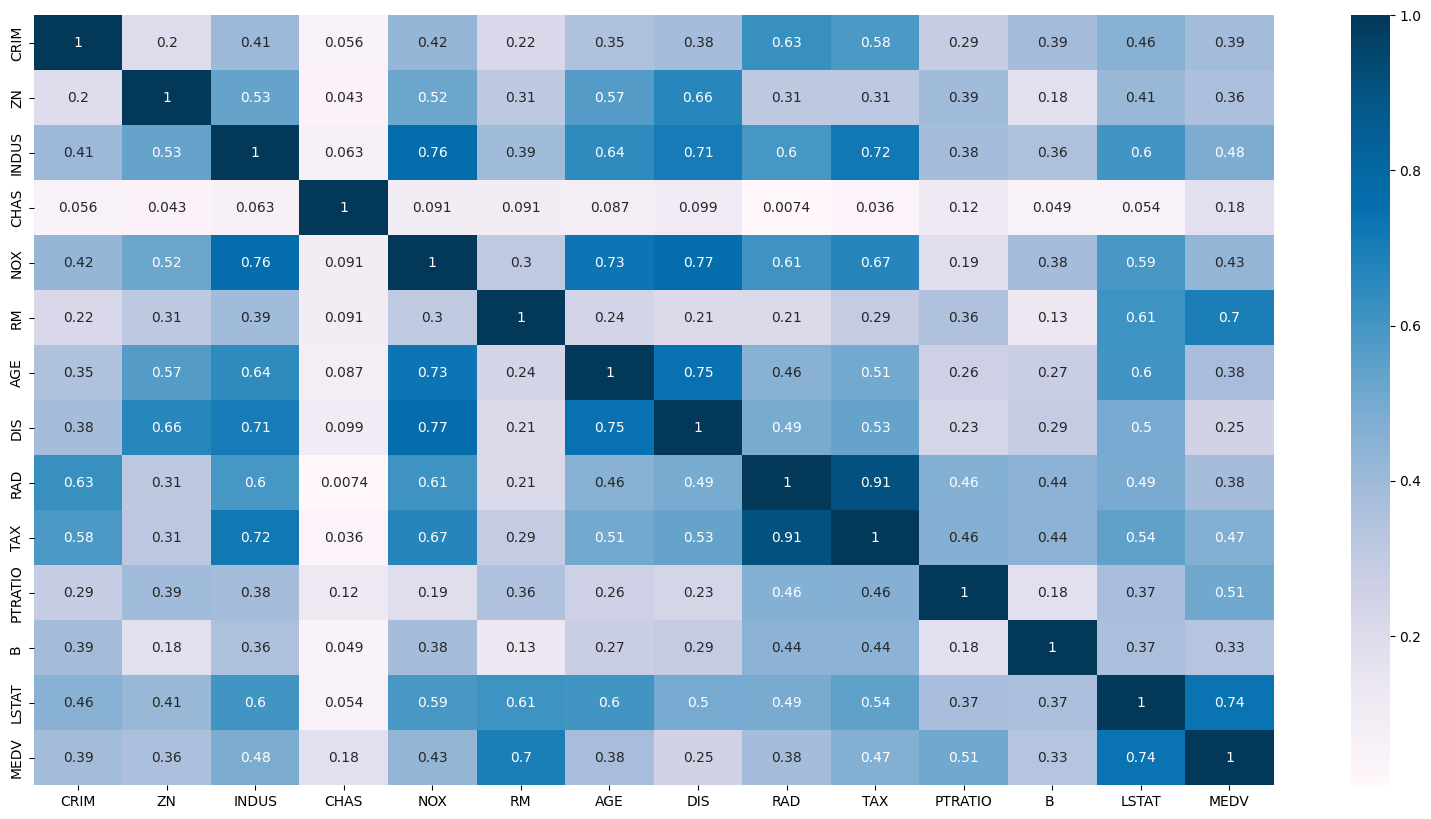

In [5]:
""" 可視化チェック"""
# 散布図行列
# sns.pairplot(raw_dataset)
# plt.show()

# heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(raw_dataset.corr().abs(),  cmap=plt.cm.PuBu, annot=True)

----
## 2. 前処理

**手順**

- 欠損データ行の除去
- ダミー変数化

In [6]:
""" 欠損データ行除去"""
dataset = raw_dataset.copy()

print(f"処理前 =============\n{dataset.isna().sum()}\n")
dataset = dataset.dropna()
print(f"処理後 =============\n{dataset.isna().sum()}")


処理前 =============
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

処理後 =============
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64


In [7]:
""" ダミー変数に変換"""
print(f"処理前 =============\n{raw_dataset.dtypes}\n")
# dataset['categorical_var'] = dataset['categorical_var'].map({1: 'value1', 2: 'value2', 3: 'value3'})
# dataset = pd.get_dummies(dataset, columns=['categorical_va'], prefix='', prefix_sep='')
print(f"処理後 =============\n{raw_dataset.dtypes}\n")

処理前 =============
CRIM       float64
ZN         float64
INDUS      float64
CHAS         int64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD          int64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
MEDV       float64
dtype: object

処理後 =============
CRIM       float64
ZN         float64
INDUS      float64
CHAS         int64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD          int64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
MEDV       float64
dtype: object



----

## 3. 訓練用データ作成

- 訓練用/テスト用にデータを分割
- 特徴量データ/ラベルデータに分割
- 正規化レイヤーの作成

In [7]:
""" 訓練用/テスト用にデータを分割"""
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [8]:
""" 特徴量データ/ラベルデータに分割"""
# for train
train_features = train_dataset.copy()
test_features = test_dataset.copy()
# for test
train_labels = train_features.pop(Context.label)
test_labels = test_features.pop(Context.label)

----

## 4. モデルアーキテクチャ構築

| モデル | アーキテクチャ | 入力層 | 出力層 | features|
| :---: | :---:| :---: | :---: | :---: | 
| 単回帰モデル | 1層 | `(,1)` | `(,1)` | `LSTAT` |
| 重回帰モデル | 1層 | `(,13)` | `(,1)` | all |
| DNN | 3層(2つの中間層を持つ) | `(,13)` | `(,1)` | all |

### 4-1. 単回帰モデル

In [9]:
""" 単回帰モデルの構築
@compile:
    `loss`:損失関数. https://keras.io/ja/losses/
        `mse`:平均二乗損失. 
        `mae`:平均絶対損失. 推定をロバストしたい場合に指定.
        `categorical_crossentropy`:交差エントロピー. カテゴリカル値のラベルに対して使う.
    `metrics`: 評価関数. モデルの評価を行う関数(学習には用いられない). 
"""


def build_simple_regress_model():
    # 正規化レイヤー
    lstat = np.array(train_features['LSTAT'])
    lstat_normalizer = layers.Normalization(input_shape=[1,], axis=None)
    lstat_normalizer.adapt(lstat)

    # 単回帰モデル
    model = keras.Sequential([
        lstat_normalizer,  # 正規化レイヤー
        layers.Dense(units=1)  # 単一の出力を持つ
    ])

    # モデルのコンパイル
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=0.05),
        loss='mae',
        metrics=['mae'])

    return model


In [10]:
""" k-分割交差検証(k-Fold cross validation)"""


class K_FoldCV:
    def __init__(self, split):
        """分割交差検証を行います

        Args:
            split (int): 分割個数
        """
        self._split = split

    def fit(self, build_model, fit, train_data, train_label):
        """分割交差検証によるモデルの訓練

        Args:
            build_model (() -> tf.keras.Model): コンパイル済みモデルのオブジェクトを返す
            fit ((model, train_data, train_label) -> keras.callbacks.History): モデルの訓練(コールバック)
            train_data (pd.DatFrame): 訓練用特徴量
            train_label (pd.DatFrame): 訓練用ラベル

        Returns:
            history_list: 訓練経過のリスト
            model_list: 訓練済みモデルのリスト
        """
        num_val_samples = len(train_data) // self._split  # 訓練データを, _split個に分割

        _train_data = train_data.to_numpy()
        _train_label = train_label.to_numpy()

        def process(i):
            # 検証用(入力)
            val_data = _train_data[i *
                                   num_val_samples: (i+1) * num_val_samples]
            # 検証用(ラベル)
            val_label = _train_label[i *
                                     num_val_samples: (i+1) * num_val_samples]

            # 学習用(入力)
            partial_train_data = np.concatenate(
                [_train_data[:i * num_val_samples],
                 _train_data[(i+1) * num_val_samples:]],
                axis=0)

            # 学習用(ラベル)
            partial_train_label = np.concatenate(
                [_train_label[:i * num_val_samples],
                 _train_label[(i+1)*num_val_samples:]],
                axis=0)

            # モデルをビルドする(まっさら)
            _model = build_model()
            # モデル訓練
            print(f"train index :{i} / {self._split - 1}")
            history = fit(_model, partial_train_data, partial_train_label)

            return history, _model
        # 並列化
        return zip(*Parallel(n_jobs=-1, verbose=1)( [delayed(process)(i) for i in range(self._split)]))


In [11]:
%%time
""" 単回帰モデルの訓練
    @param:
        batch_size: ミニバッチ学習に使うサンプルサイズ(既定値=32). 慣例として2の冪乗の整数を指定. 数百件データでは, 16, 32, 64を選び, 数万件規模データでは, より大きい数値を選ぶ.
"""


def fit(model, train_data, train_label):
    return model.fit(
        train_data,
        train_label,
        epochs=100,
        batch_size=16,
        verbose=0,
        validation_split=0.2)

kf = K_FoldCV(4)  # 4分割交差検証
sr_history_list, sr_model_list = kf.fit(
    build_simple_regress_model, # 単回帰モデル
    fit, 
    train_features['LSTAT'],
    train_labels)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Metal device set to: Apple M1

systemMemory: 16.00 GB
Metal device set to: Apple M1
maxCacheSize: 5.33 GB


systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1Metal device set to: Apple M1


systemMemory: 16.00 GB
maxCacheSize: 5.33 GB


systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-02-01 22:55:48.398272: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-01 22:55:48.398279: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-01 22:55:48.398405: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-01 22:55:48.398516: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL,

train index :1 / 3


2023-02-01 22:55:49.117554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-01 22:55:49.450407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


train index :0 / 3
train index :3 / 3
train index :2 / 3


2023-02-01 22:55:49.739530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-01 22:55:49.757211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-01 22:55:49.758323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-01 22:55:50.939426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-01 22:55:50.939426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-01 22:55:50.939798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-02-01 22:56:02.134041: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-01 22:56:02.134326: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


CPU times: user 1.04 s, sys: 181 ms, total: 1.22 s
Wall time: 18.5 s


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   18.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   18.5s finished


In [12]:
def plot_loss(history_list, ylim=[0, 10]):
    p = len(history_list)

    fig = plt.figure(figsize=[8, 8])
    plt.subplots_adjust(wspace=0.4, hspace=0.5)  # グラフ間隔

    for i in range(p):
        ax = fig.add_subplot(p, 1, i + 1, title=f"train {i}")
        ax.set_aspect('equal')  # アスペクト比の調整
        ax.plot(history_list[i].history['loss'], label='loss')
        ax.plot(history_list[i].history['val_loss'], label='val_loss')
        ax.grid(axis='both')
        ax.legend()
        ax.set_xlabel('Epoch')
        ax.set_ylabel(f'Error [{Context.label}]')
        ax.set_ylim(ylim)

    fig.tight_layout()
    fig.show()

/var/folders/sj/c729ktr51mlb1pft9rgqm95h0000gn/T/ipykernel_95475/3828951180.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


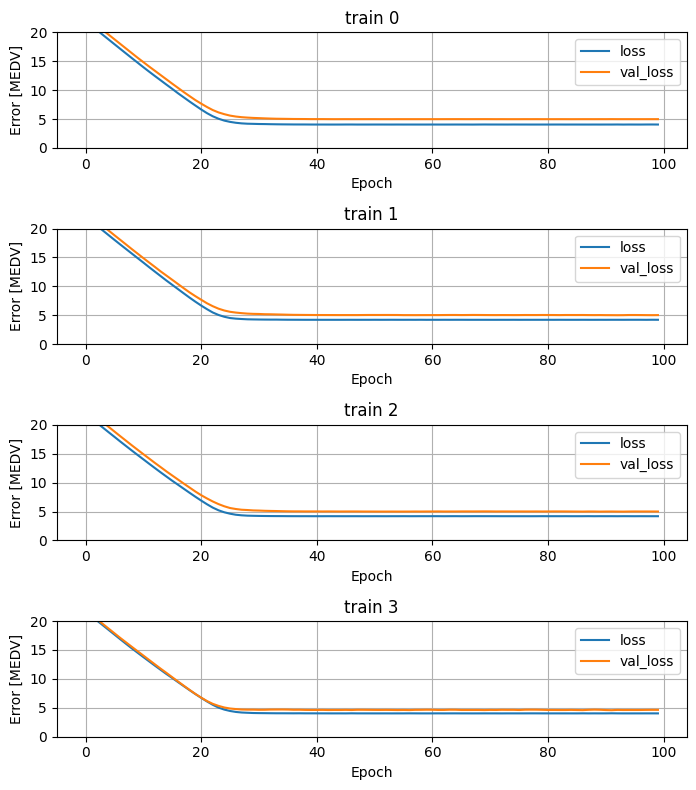

In [13]:
plot_loss(sr_history_list, ylim=[0, 20])

### 4-2. 重回帰モデル

In [14]:
""" 重回帰モデルの構築
@params:
    `loss`:損失関数. https://keras.io/ja/losses/
        `mse`:平均二乗損失. 
        `mae`:平均絶対損失. 推定をロバストしたい場合に指定.
        `categorical_crossentropy`:交差エントロピー. カテゴリカル値のラベルに対して使う.
    `metrics`: 評価関数. モデルの評価を行う関数(学習には用いられない). 
"""


def build_multi_regress_model():
    # 正規化レイヤー
    normalizer = layers.Normalization() # `axis`:Defaultでは, すべての特徴量を対象に正規化が実行される.
    normalizer.adapt(np.array(train_features))
    
    # 重回帰モデル
    model = tf.keras.Sequential([
        normalizer,
        layers.Dense(units=1)
    ])

    # モデルのコンパイル
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=0.005),
        loss='mae',
        metrics=['mae'])

    return model


In [15]:
%%time
""" 重回帰モデルの訓練"""

mr_history_list, mr_model_list = kf.fit(
    build_multi_regress_model, # 重回帰モデル
    fit,
    train_features,
    train_labels)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
2023-02-01 22:56:48.056620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-01 22:56:48.073792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


train index :1 / 3


2023-02-01 22:56:48.723442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-01 22:56:49.251428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-02-01 22:56:49.754988: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-01 22:56:49.755110: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-01 22:56:49.755498: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-01 22:56:49.755610: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL,

train index :3 / 3
train index :2 / 3
train index :0 / 3


2023-02-01 22:56:51.033495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-01 22:56:51.033809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-01 22:56:51.034409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-01 22:56:52.451773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-01 22:56:52.454475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-01 22:56:52.457404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


CPU times: user 831 ms, sys: 41.6 ms, total: 872 ms
Wall time: 17.4 s


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   17.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   17.4s finished


/var/folders/sj/c729ktr51mlb1pft9rgqm95h0000gn/T/ipykernel_95475/3828951180.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


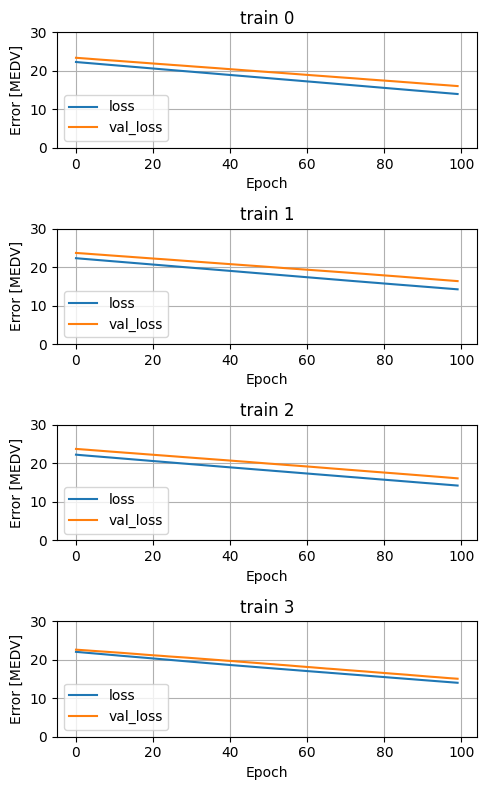

In [16]:
plot_loss(mr_history_list, ylim=[0, 30])

### 4-3. DNNモデル

In [17]:
""" モデルのコンパイル
@layers:
    layers.Dense(1): スカラー
    layers.Dense(K, activation='softmax'): Kクラスの分類

@compile:
    `loss`:損失関数. https://keras.io/ja/losses/
        `mse`:平均二乗損失. 
        `mae`:平均絶対損失. 推定をロバストしたい場合に指定.
        `categorical_crossentropy`:交差エントロピー. カテゴリカル値のラベルに対して使う.
    `metrics`: 評価関数. モデルの評価を行う関数(学習には用いられない). 
"""


def build_dnn_model():
    # 正規化レイヤー
    normalizer = layers.Normalization() # `axis`:Defaultでは, すべての特徴量を対象に正規化が実行される.
    normalizer.adapt(np.array(train_features))
    
    # DNNモデルの定義
    model = keras.Sequential([
        normalizer,  # 正規化レイヤー
        layers.Dense(32, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)  # 出力層
    ])
    
    # モデルのコンパイル
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=0.005),
        loss='mae',
        metrics=['mae'])

    return model


In [18]:
%%time
""" DNNモデルの訓練"""
dnn_history_list, dnn_model_list = kf.fit(
    build_dnn_model,
    fit,
    train_features,
    train_labels)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
2023-02-01 22:57:15.868763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-01 22:57:15.875304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-01 22:57:15.880253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-01 22:57:15.887047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-01 22:57:15.892951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-01 22:57:15.897884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is ena

train index :3 / 3


2023-02-01 22:57:16.326627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


train index :2 / 3
train index :0 / 3


2023-02-01 22:57:16.693467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-01 22:57:16.695325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-02-01 22:57:17.812950: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-01 22:57:17.813075: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-01 22:57:17.834914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-01 22:57:17.965944: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-01 22:57:18.051842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-01 22:57:18.080504: I tensorflow/core/grappler/o

train index :1 / 3


2023-02-01 22:57:19.410536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-01 22:57:21.934433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


CPU times: user 1.27 s, sys: 70.6 ms, total: 1.34 s
Wall time: 20.7 s


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   20.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   20.7s finished


/var/folders/sj/c729ktr51mlb1pft9rgqm95h0000gn/T/ipykernel_95475/3828951180.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


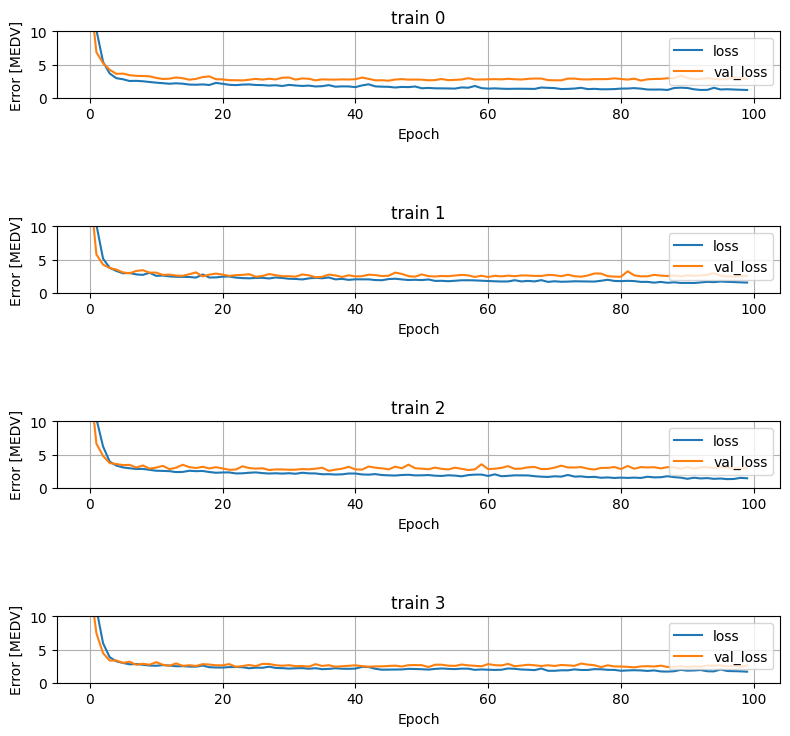

In [19]:
plot_loss(dnn_history_list, ylim=[0, 10])

----
## 5 モデル同士の性能比較

In [20]:
""" テスト用データで損失(MAE)とスコア(MAE)を評価

3つのモデル(単回帰モデル, 重回帰モデル, DNNモデル)について各フォールドで訓練したモデルの, 損失と性能の平均, 標準偏差を算出
"""
test_results = pd.concat([
    pd.DataFrame([model.evaluate(test_features['LSTAT'], test_labels, verbose=0)
                 for model in sr_model_list], columns=['SRM_loss', 'SRM_MAE']),  # 単回帰モデル
    pd.DataFrame([model.evaluate(test_features, test_labels, verbose=0)
                 for model in mr_model_list], columns=['MRM_loss', 'MRM_MAE']),  # 重回帰モデル
    pd.DataFrame([model.evaluate(test_features, test_labels, verbose=0)
                 for model in dnn_model_list], columns=['DNN_loss', 'DNN_MAE']),  # DNNモデル
], axis='columns')

test_results.describe().loc[['mean', 'std']].T


2023-02-01 22:58:10.464198: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-01 22:58:10.512697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-01 22:58:10.983349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-01 22:58:11.084522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-01 22:58:11.187530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-01 22:58:11.291999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-01 22:58:11.544945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113

,mean,std
SRM_loss,4.24,0.02
SRM_MAE,4.24,0.02
MRM_loss,15.00,0.14
MRM_MAE,15.00,0.14
DNN_loss,2.25,0.07
DNN_MAE,2.25,0.07


4/4 [==============================] - 0s 6ms/step


2023-02-01 22:58:53.529147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-01 22:58:53.633698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-01 22:58:53.714928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 6ms/step


2023-02-01 22:58:53.928935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


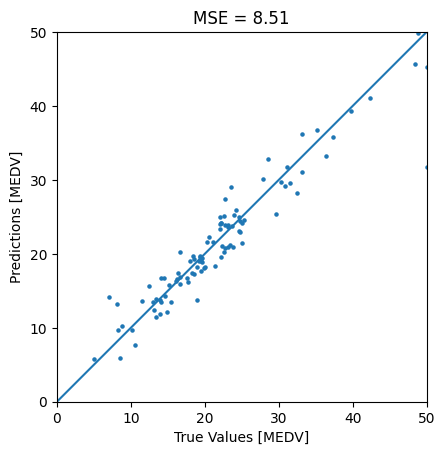

In [21]:
""" DNNモデルの予測値 - 推定値プロット"""
# 各フォールドで訓練したモデルの予測値の平均値
test_predictions = np.mean([model.predict(test_features).flatten() for model in dnn_model_list], axis=0)

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions, s=5)
plt.xlabel(f'True Values [{Context.label}]')
plt.ylabel(f'Predictions [{Context.label}]')
lims = [0, 50]
plt.title(f"MSE = {tf.keras.metrics.mean_squared_error(test_predictions, test_labels):.3g}")
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)